# Parameters

In [51]:
# PARAMETERS
swell_threshold = 1.0 # m
current_threshold = 0.8 # m/s
tolerance = 1 # +/- tolerance in entire hours (1 for a 2-hour working window)

# DATE FILTERS

filter_dates = False # Set to True to filter the data by date
date_start = '01/01/2022' # Start date of the period of interest
date_end = '31/12/2022' # End date of the period of interest

# DAYTIME FILTERS
daytime_only = False # Set to True to only consider the daytime
daytime_start = '07:00' # Start time of the daytime
daytime_end = '19:00' # End time of the daytime

# EXPORT
export_data = True # Set to True to export the data
export_figs = True # Set to True to export the figures

# Import and processing

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# CURRENT DATA IMPORT
current = pd.DataFrame()
for file in os.listdir('data/current/'):
    current = pd.concat([current, pd.read_csv('data/current/' + file, sep=';' , decimal=",")]).iloc[:,:11]

current['Current'] = np.max(current.iloc[:,1:], axis=1)
current = (
    current
    .drop(current.columns[1:11], axis=1)
    .rename(columns={'UTC datetime':'datetime', 'Current':'current'})
    .astype({'datetime': 'datetime64[ns]'})
    .set_index('datetime')
)

# SWELL DATA IMPORT
swell = pd.DataFrame()
for file in os.listdir('data/swell/'):
    swell = pd.concat([swell, pd.read_csv('data/swell/' + file, sep=';' , decimal=",", skiprows=7, header=0)]).iloc[:,[0,5]]

swell = (
    swell
    .rename(columns={'UTC datetime':'datetime', 'Hm0(m)': 'hm0'})
    .astype({'datetime': 'datetime64[ns]'})
    .set_index('datetime')
)

# MERGE CURRENT AND SWELL DATA, ORDER BY DATE AND FILL MISSING VALUES
data = (
    pd.concat([current, swell], axis=1, sort=True)
    .fillna(method='ffill')
    .fillna(method='bfill')
)

# STANBY WINDOWS COMPUTATIION
swell_left_max= data.rolling('{:b}h'.format(tolerance)).max()['hm0']
swell_right_max= data[::-1].rolling('{:b}h'.format(tolerance)).max()['hm0']
current_left_max= data.rolling('{:b}h'.format(tolerance)).max()['current']
current_right_max= data[::-1].rolling('{:b}h'.format(tolerance)).max()['current']

data['standby'] = np.logical_or(
    np.logical_and(current_left_max > current_threshold, current_left_max > current_threshold),
    np.logical_and(swell_left_max > swell_threshold, swell_right_max > swell_threshold)
)

# TIME CONVERSION
data['time_span'] = -data.index.to_series().diff(-1)
data['standy_time'] = -data.index.to_series().diff(-1)*data['standby']

# DATE FILTERS
if filter_dates:
    data = data.loc[
        (data.index >= pd.to_datetime(date_start)) & (data.index <= pd.to_datetime(date_end)),
        :
    ]

# DAYTIME FILTERS
if daytime_only:
    data = data.loc[
        (data.index.time >= pd.to_datetime(daytime_start).time()) & (data.index.time <= pd.to_datetime(daytime_end).time()),
        :
    ]

# STANDNBY RATIO COMPUTATION
print(
    'Stand-by time: {:.1f}% of total time'.format(
        data['standy_time'].sum()/data['time_span'].sum()*100
    )
)

data

Stand-by time: 23.7% of total time


,current,hm0,standby,time_span,standy_time
datetime,,,,,
2022-04-01 00:04:00,0.537,2.53,True,0 days 00:03:00,0 days 00:03:00
2022-04-01 00:07:00,0.537,2.53,True,0 days 00:07:00,0 days 00:07:00
2022-04-01 00:14:00,0.576,2.53,True,0 days 00:10:00,0 days 00:10:00
2022-04-01 00:24:00,0.560,2.53,True,0 days 00:10:00,0 days 00:10:00
2022-04-01 00:34:00,0.547,2.53,True,0 days 00:03:00,0 days 00:03:00
...,...,...,...,...,...
2022-06-12 21:24:00,0.398,0.57,False,0 days 00:10:00,0 days 00:00:00
2022-06-12 21:34:00,0.441,0.57,False,0 days 00:07:00,0 days 00:00:00
2022-06-12 21:41:00,0.441,0.57,False,0 days 00:03:00,0 days 00:00:00


# Plots

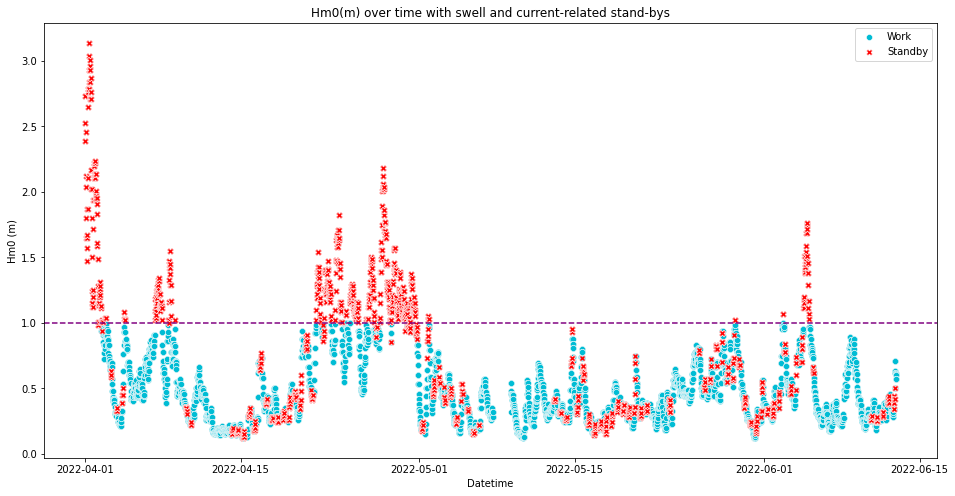

In [57]:
fig = plt.figure(figsize=(16, 8))
ax = sns.scatterplot(
    x='datetime',
    y='hm0',
    data=data[data['standby']==False],
    color='#00bcd4',
    label='Work'
)
sns.scatterplot(
    x='datetime',
    y='hm0',
    data=data[data['standby']==True],
    color='red',
    marker='X',
    label='Standby'
)
ax.axhline(y=swell_threshold, color='purple', linestyle='--')
ax.set(
    xlabel='Datetime',
    ylabel='Hm0 (m)',
    title='Hm0(m) over time with swell and current-related stand-bys'
)

# SAVING FIGURE
if export_figs:
    if not os.path.exists('./results'):
        os.makedirs('./results')
    fig.savefig('results/swell_standbys.png')

plt.show()

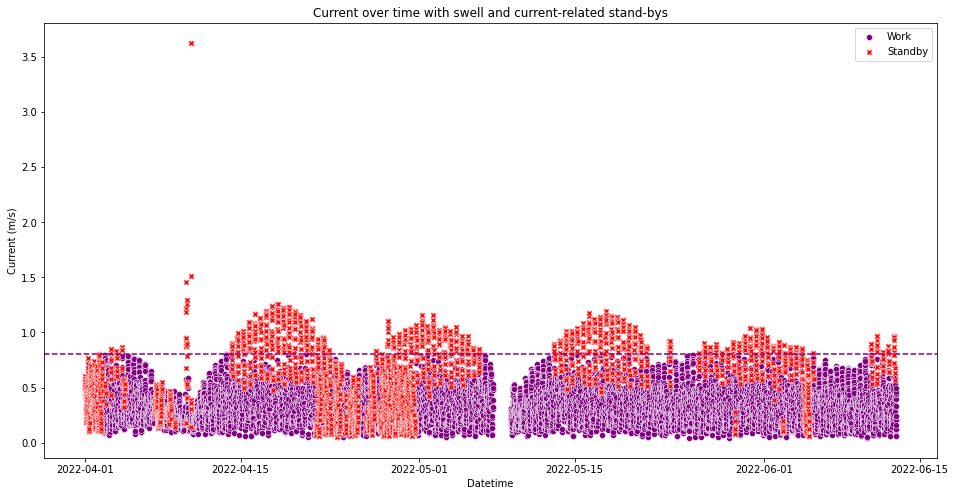

In [59]:
fig = plt.figure(figsize=(16, 8))
ax = sns.scatterplot(
    x='datetime',
    y='current',
    data=data[data['standby']==False],
    color='purple',
    label='Work'
)
sns.scatterplot(
    x='datetime',
    y='current',
    data=data[data['standby']==True],
    color='red',
    marker='X',
    label='Standby'
)
ax.axhline(y=current_threshold, color='purple', linestyle='--')
ax.set(
    xlabel='Datetime',
    ylabel='Current (m/s)',
    title='Current over time with swell and current-related stand-bys'
)

# SAVING FIGURE
if export_figs:
    if not os.path.exists('./results'):
        os.makedirs('./results')
    fig.savefig('results/current_standbys.png')

plt.show()

# Statistics & file export

In [60]:
standbys = data.loc[
    data['standby'] == True,
    ['hm0', 'current', 'standby', 'standy_time']
]
if export_data:
    if not os.path.exists('./results'):
        os.makedirs('./results')
    standbys.to_csv('results/standbys.csv', sep=';')
    standbys.to_excel('results/standbys.xlsx')
        
standbys.describe()

,hm0,current,standy_time
count,3227.000000,3227.000000,3227
mean,0.932008,0.599742,0 days 00:07:42.448094205
std,0.577310,0.314643,0 days 00:03:03.857761317
min,0.120000,0.051000,0 days 00:01:00
25%,0.380000,0.325000,0 days 00:05:00
50%,1.020000,0.610000,0 days 00:10:00
75%,1.250000,0.848000,0 days 00:10:00
max,3.140000,3.629000,0 days 00:20:00


In [63]:
print('Sea state general statistics')
data[['hm0', 'current']].describe()

Sea state general statistics


,hm0,current
count,13342.000000,13342.000000
mean,0.559095,0.411315
std,0.399244,0.239662
min,0.120000,0.042000
25%,0.290000,0.218000
50%,0.430000,0.367000
75%,0.710000,0.549000
max,3.140000,3.629000
